# EECS 442 Homework 4: Fashion-MNIST Classification
In this part, you will implement and train Convolutional Neural Networks (ConvNets) in PyTorch to classify images. Unlike HW4 Secion 1, backpropagation is automatically inferred by PyTorch, so you only need to write code for the forward pass.

Before we start, please put your name and UMID in following format

: Ryan SHAW, #93380072  

**Your Answer:**   
Hello Ryan SHAW #93380072

## Setup

In [ ]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split

In [ ]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


## Loading Dataset
The dataset we use is Fashion-MNIST dataset, which is available at https://github.com/zalandoresearch/fashion-mnist and in torchvision.datasets. Fashion-MNIST has 10 classes, 60000 training+validation images (we have splitted it to have 50000 training images and 10000 validation images, but you can change the numbers), and 10000 test images.

In [ ]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
# Transform from [0,255] uint8 to [0,1] float,
# then normalize to zero mean and unit variance
FASHION_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.2859], [0.3530]) 
                    ])
FASHION_trainval = datasets.FashionMNIST('.', download=True, train=True,
                                         transform=FASHION_transform)
FASHION_train = Subset(FASHION_trainval, range(50000))
FASHION_val = Subset(FASHION_trainval, range(50000, 60000))
FASHION_test = datasets.FashionMNIST('.', download=True, train=False,
                                     transform=FASHION_transform)
print("Done!")

Loading datasets...


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Done!


Now, we will create the dataloder for train, val and test dataset. You are free to experiment with different batch sizes.

In [ ]:
# Create dataloaders
##############################################################################
# TODO: Experiment with different batch sizes                                #
##############################################################################
batch_size=256
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
trainloader = DataLoader(FASHION_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(FASHION_val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(FASHION_test, batch_size=batch_size, shuffle=True)

## Model
Initialize your model and experiment with with different optimizers, parameters (such as learning rate) and number of epochs.

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        ##############################################################################
        # TODO: Design your own network, define layers here.                          #
        # Here We provide a sample of two-layer fc network from HW4 Part3.           #
        # Your solution, however, should contain convolutional layers.               #
        # Refer to PyTorch documentations of torch.nn to pick your layers.           #
        # (https://pytorch.org/docs/stable/nn.html)                                  #
        # Some common choices: Linear, Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout   #
        # If you have many layers, use nn.Sequential() to simplify your code         #
        ##############################################################################
        #downsampling
        self.conv1 = nn.Conv2d(1,64,kernel_size=3, stride=2, padding=1) #14x14x64
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) #7x7x64

        #classifier
        self.conv2 = nn.Conv2d(64,64,kernel_size=3, stride=1, padding=1) #7x7x64
        self.conv3 = nn.Conv2d(64,16,kernel_size=3, stride=2, padding=1) #4x4x16 (stride=2 make 7->4, 64->16)
        self.lin = nn.Linear(256,10)
        
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
  
    def forward(self, x):
        ##############################################################################
        # TODO: Design your own network, implement forward pass here                 # 
        ##############################################################################
        x = x.to(device)
        relu = nn.LeakyReLU()

        # Flatten each image in the batch
        x = self.conv1(x)
        x = relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = relu(x)
        # # No need to define self.relu because it contains no parameters
        
        x = self.conv3(x)
        x = relu(x)

        x = x.view(x.size(0), -1)
        x = self.lin(x)
        # The loss layer will be applied outside Network class
        return x
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (1,28,28), device=device)) # visualize your model

##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
# Set up optimization hyperparameters
learning_rate = 3e-3
weight_decay = 1e-5
num_epoch = 10  # TODO: Choose an appropriate number of training epochs
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                       weight_decay=weight_decay) # Try different optimizers
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
         AvgPool2d-2             [-1, 64, 7, 7]               0
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Conv2d-4             [-1, 16, 4, 4]           9,232
            Linear-5                   [-1, 10]           2,570
Total params: 49,370
Trainable params: 49,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.19
Estimated Total Size (MB): 0.34
----------------------------------------------------------------
None


Run the cell below to start your training, we expect you to achieve over **85%** on the test set. A valid solution that meet the requirement take no more than **10 minutes** on normal PC Intel core CPU setting. If your solution takes too long to train, try to simplify your model or reduce the number of epochs.

In [ ]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        for batch, label in tqdm(trainloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, trainloader,
                                                  valloader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, testloader)

Start training...
-----------------Epoch = 1-----------------


100%|██████████| 196/196 [00:14<00:00, 13.72it/s]



 Epoch 1 loss:0.6317927718770747


100%|██████████| 196/196 [00:13<00:00, 14.54it/s]



 Evaluation accuracy: 0.83622

 Evaluate on validation set...


100%|██████████| 40/40 [00:02<00:00, 15.98it/s]



 Evaluation accuracy: 0.8314
-----------------Epoch = 2-----------------


100%|██████████| 196/196 [00:13<00:00, 14.40it/s]



 Epoch 2 loss:0.39412436527865274


100%|██████████| 196/196 [00:13<00:00, 14.91it/s]



 Evaluation accuracy: 0.87268

 Evaluate on validation set...


100%|██████████| 40/40 [00:02<00:00, 14.29it/s]



 Evaluation accuracy: 0.8672
-----------------Epoch = 3-----------------


100%|██████████| 196/196 [00:14<00:00, 13.96it/s]



 Epoch 3 loss:0.34364380573435704


100%|██████████| 196/196 [00:14<00:00, 13.87it/s]



 Evaluation accuracy: 0.88444

 Evaluate on validation set...


100%|██████████| 40/40 [00:02<00:00, 15.79it/s]



 Evaluation accuracy: 0.8779
-----------------Epoch = 4-----------------


100%|██████████| 196/196 [00:13<00:00, 14.29it/s]



 Epoch 4 loss:0.3102724378054239


100%|██████████| 196/196 [00:13<00:00, 14.70it/s]



 Evaluation accuracy: 0.8942

 Evaluate on validation set...


100%|██████████| 40/40 [00:02<00:00, 15.59it/s]



 Evaluation accuracy: 0.8857
-----------------Epoch = 5-----------------


100%|██████████| 196/196 [00:13<00:00, 14.18it/s]



 Epoch 5 loss:0.2863308720442714


100%|██████████| 196/196 [00:13<00:00, 14.48it/s]



 Evaluation accuracy: 0.89826

 Evaluate on validation set...


100%|██████████| 40/40 [00:03<00:00, 13.24it/s]



 Evaluation accuracy: 0.8871
-----------------Epoch = 6-----------------


100%|██████████| 196/196 [00:13<00:00, 14.26it/s]



 Epoch 6 loss:0.2673810159369391


100%|██████████| 196/196 [00:13<00:00, 14.84it/s]



 Evaluation accuracy: 0.91008

 Evaluate on validation set...


100%|██████████| 40/40 [00:02<00:00, 15.72it/s]



 Evaluation accuracy: 0.8927
-----------------Epoch = 7-----------------


100%|██████████| 196/196 [00:13<00:00, 14.41it/s]



 Epoch 7 loss:0.25236896250625046


100%|██████████| 196/196 [00:14<00:00, 13.88it/s]



 Evaluation accuracy: 0.91448

 Evaluate on validation set...


100%|██████████| 40/40 [00:02<00:00, 13.41it/s]



 Evaluation accuracy: 0.9009
-----------------Epoch = 8-----------------


100%|██████████| 196/196 [00:14<00:00, 13.94it/s]



 Epoch 8 loss:0.23841125457262508


100%|██████████| 196/196 [00:13<00:00, 14.73it/s]



 Evaluation accuracy: 0.91944

 Evaluate on validation set...


100%|██████████| 40/40 [00:02<00:00, 15.82it/s]



 Evaluation accuracy: 0.9024
-----------------Epoch = 9-----------------


100%|██████████| 196/196 [00:13<00:00, 14.21it/s]



 Epoch 9 loss:0.22995788695252672


100%|██████████| 196/196 [00:13<00:00, 14.82it/s]



 Evaluation accuracy: 0.92446

 Evaluate on validation set...


100%|██████████| 40/40 [00:02<00:00, 15.63it/s]



 Evaluation accuracy: 0.904
-----------------Epoch = 10-----------------


100%|██████████| 196/196 [00:13<00:00, 14.36it/s]



 Epoch 10 loss:0.21988729767653406


100%|██████████| 196/196 [00:13<00:00, 14.84it/s]



 Evaluation accuracy: 0.92346

 Evaluate on validation set...


100%|██████████| 40/40 [00:03<00:00, 12.48it/s]



 Evaluation accuracy: 0.8988
Done!

 Evaluate on test set


100%|██████████| 40/40 [00:02<00:00, 16.35it/s]


 Evaluation accuracy: 0.8961
CPU times: user 4min 56s, sys: 2.22 s, total: 4min 58s
Wall time: 5min 2s


0.8961

Once your training is complete, run the cell below to visualize the training and validation accuracies across iterations.

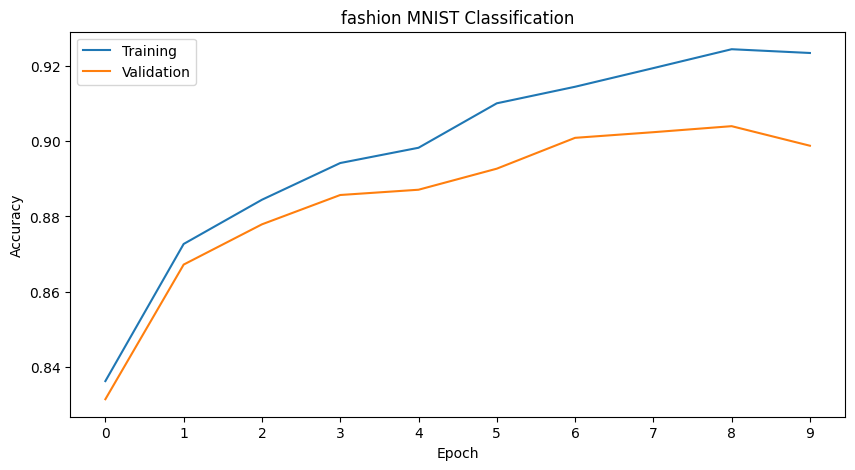

In [ ]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fashion MNIST Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()